In [1]:
# Importação de Bibliotecas
import os, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif

import joblib

# Configurações Globais
DATA_URL = 'https://raw.githubusercontent.com/MathMachado/DSWP/refs/heads/master/Dataframes/Car_Insurance_Claim.csv'
TARGET_COL = 'outcome'        # Target do dataset
ID_COL = 'id'                 # Coluna de identificação
RANDOM_STATE = 42
OUTPUT_DIR = 'pipeline_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Definição da Função de Limpeza de Nomes de Colunas
def clean_column_names(df):
    """Aplica lowercase e remove caracteres especiais dos nomes das colunas."""
    df = df.copy()
    # 1. Aplicar lowercase em todas as colunas
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    # 2. Excluir caracteres especiais dos nomes das colunas
    df.columns = [''.join(ch for ch in c if ch.isalnum() or ch == '_') for c in df.columns]
    return df

In [2]:
print("Iniciando Pipeline de ML...")
try:
    print("\n Carregando dataset...")
    df = pd.read_csv(DATA_URL)
    
    # Aplica lowercase e remove caracteres especiais
    df = clean_column_names(df)

    print("Dataset carregado! Formato:", df.shape)
    print(df.head())

    # 3. IDENTIFICAÇÃO DE TIPOS
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Remover target das listas de features (ID é tratado separadamente)
    numeric_cols = [c for c in numeric_cols if c != TARGET_COL]
    categorical_cols = [c for c in categorical_cols if c != TARGET_COL]

    print("\nNuméricas:", numeric_cols)
    print("Categóricas:", categorical_cols)

except Exception as e:
    df = None # Define df como None se falhar
    print(f"\nERRO: Falha crítica ao carregar os dados da URL. O pipeline não será executado. Detalhes: {e}")

Iniciando Pipeline de ML...

 Carregando dataset...
Dataset carregado! Formato: (10000, 19)
       id    age  gender      race driving_experience    education  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          income  credit_score  vehicle_ownership vehicle_year  married  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   children  postal_code  annual_mil

In [3]:
if df is not None:
    def winsorize_iqr(df, cols):
        """Aplica winsorização (limitando a 1.5*IQR) nas colunas numéricas."""
        df = df.copy()
        for col in cols:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            df[col] = df[col].clip(lower, upper)
        return df

    # Converte e aplica Winsorização
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = winsorize_iqr(df, numeric_cols)
    print("Outliers tratados por Winsorização IQR nas colunas numéricas.")
else:
    print("Pulando Tratamento de Outliers. DataFrame não carregado.")

Outliers tratados por Winsorização IQR nas colunas numéricas.



--- 4.5. Análise Exploratória de Dados (EDA) ---


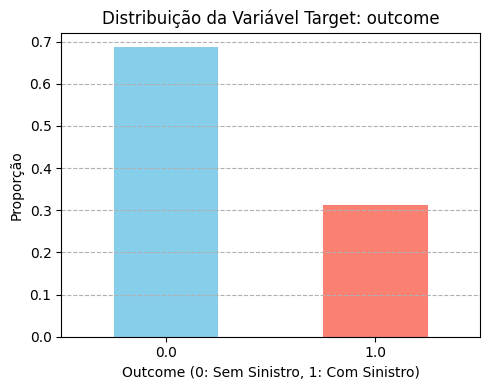

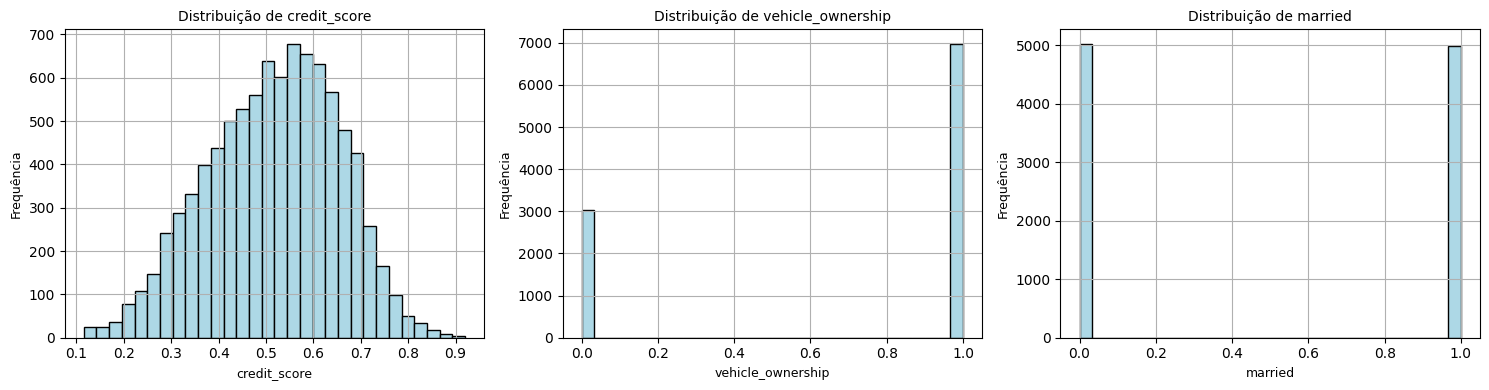

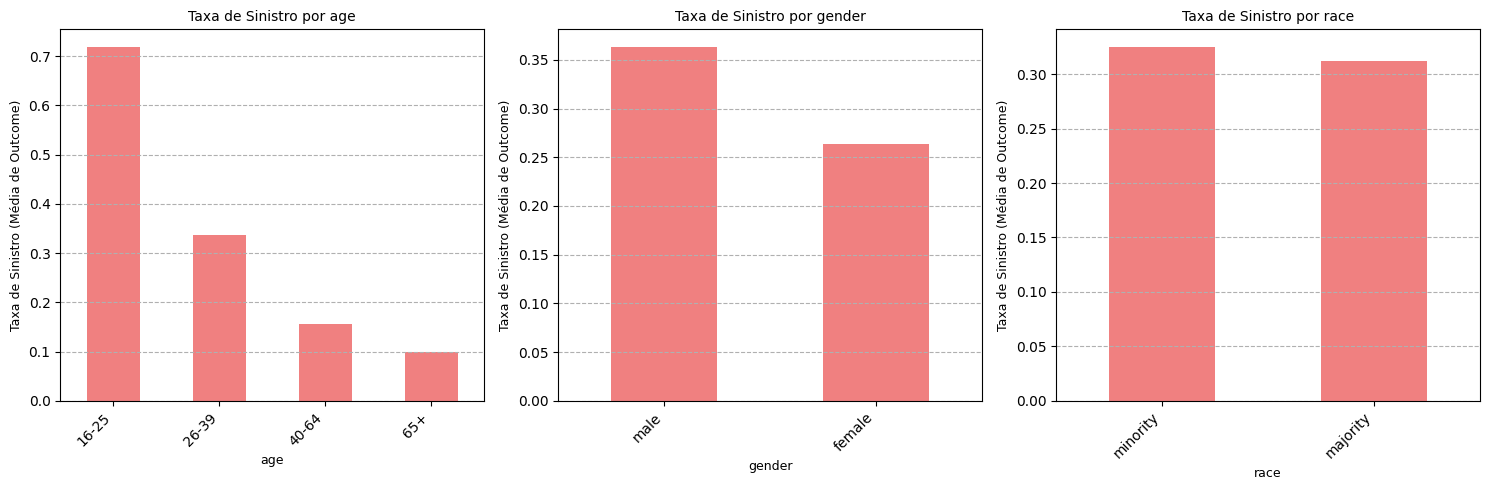

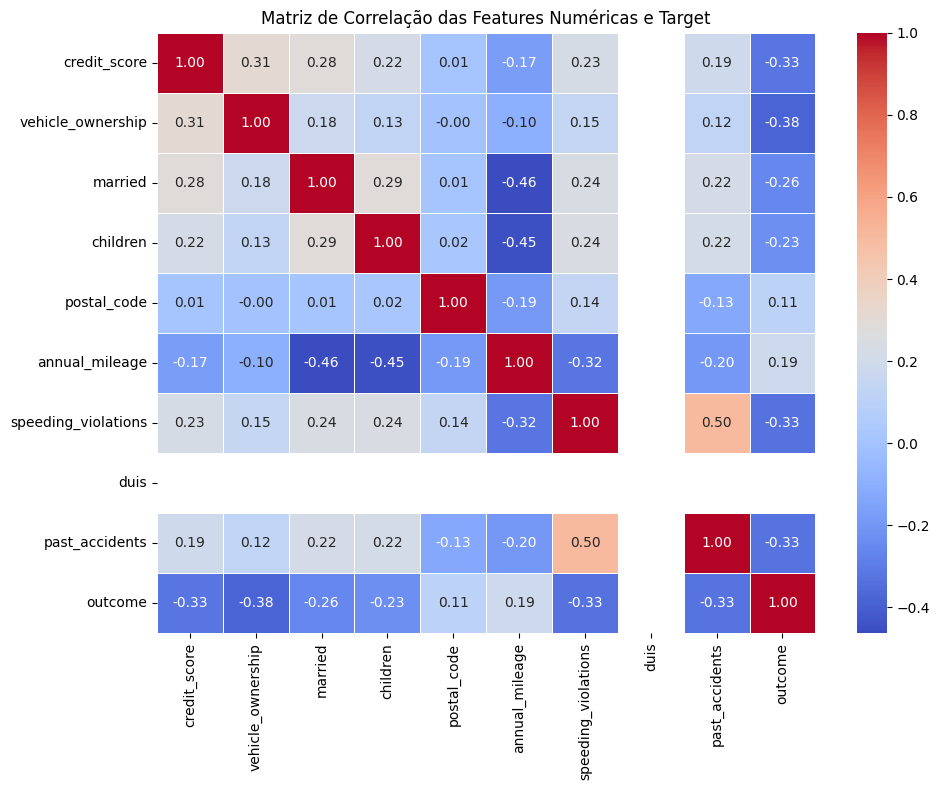

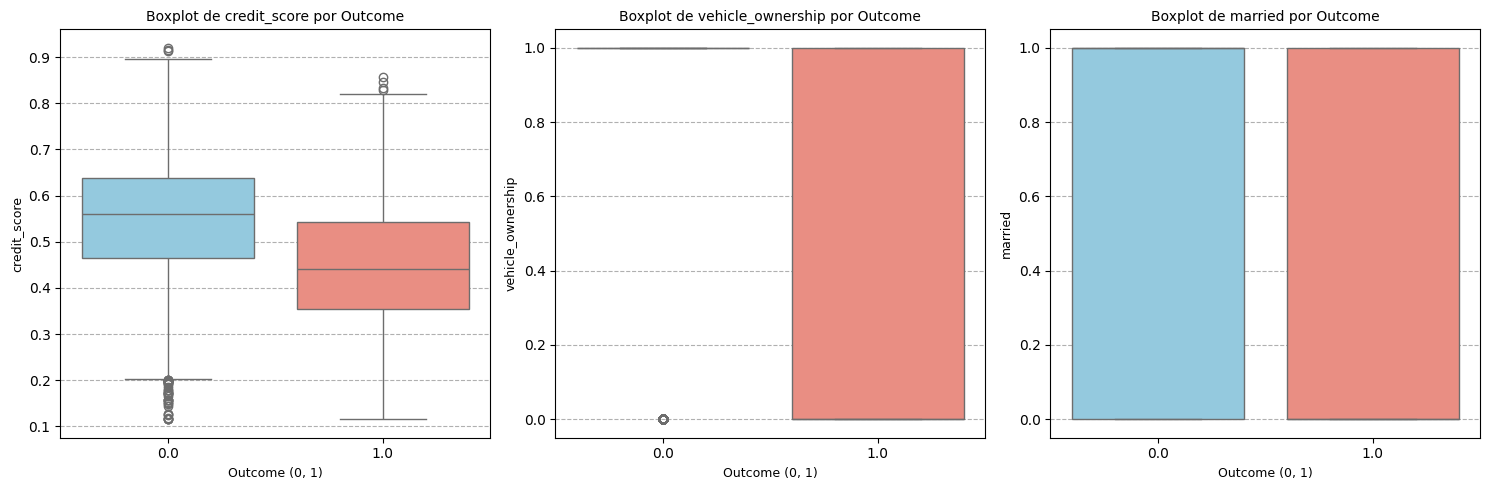

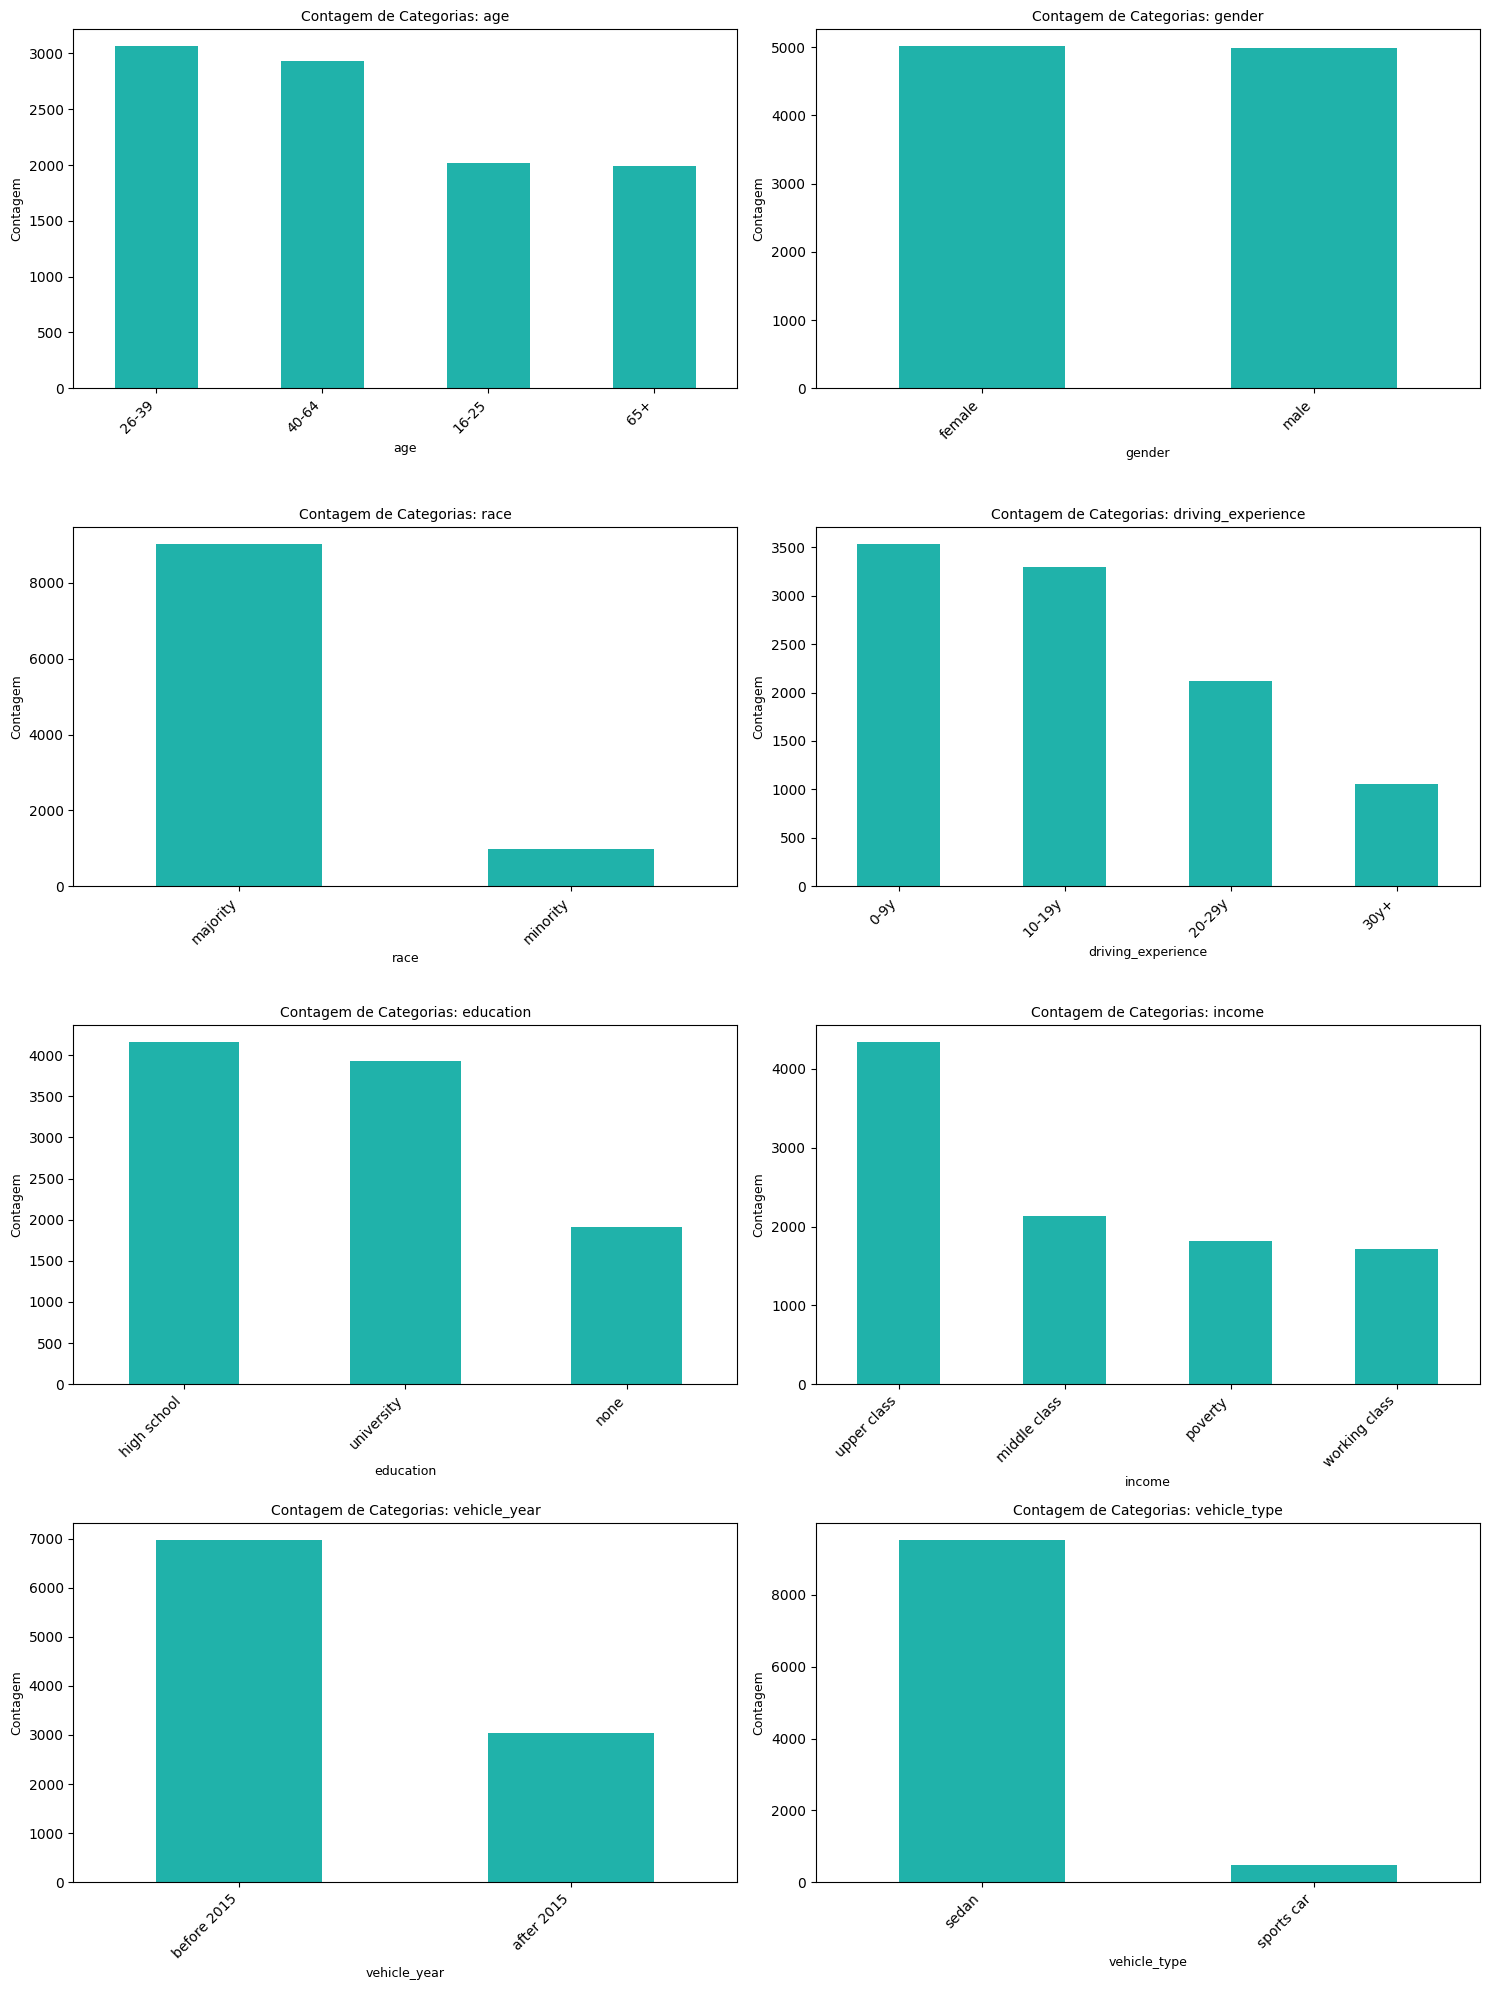


EDA concluída (6 gráficos gerados).


In [4]:
if df is not None:
    print("\n--- 4.5. Análise Exploratória de Dados (EDA) ---")

    # 4.5.1. Target Distribution
    plt.figure(figsize=(5, 4))
    df[TARGET_COL].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribuição da Variável Target: {TARGET_COL}')
    plt.xlabel('Outcome (0: Sem Sinistro, 1: Com Sinistro)')
    plt.ylabel('Proporção')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_target_distribution.png")
    plt.show()

    # 4.5.2. Numerical Feature Distributions (Primeiras 3 - Sem 'id')
    num_cols_dist = [c for c in numeric_cols if c != ID_COL][:3]
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(num_cols_dist):
        plt.subplot(1, 3, i + 1)
        df[col].hist(bins=30, edgecolor='black', color='lightblue')
        plt.title(f'Distribuição de {col}', fontsize=10)
        plt.xlabel(col, fontsize=9)
        plt.ylabel('Frequência', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_numeric_distributions.png")
    plt.show()

    # 4.5.3. Categorical Feature vs Target (Taxa de Risco - Primeiras 3)
    cat_cols_eda = categorical_cols[:3]
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(cat_cols_eda):
        ax = plt.subplot(1, 3, i + 1)
        risk_rate = df.groupby(col)[TARGET_COL].mean().sort_values(ascending=False)
        risk_rate.plot(kind='bar', color='lightcoral')
        plt.title(f'Taxa de Sinistro por {col}', fontsize=10)
        plt.xlabel(col, fontsize=9)
        plt.ylabel('Taxa de Sinistro (Média de Outcome)', fontsize=9)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_categorical_risk_rate.png")
    plt.show()


    # 4.5.4. Análise de Correlação (Heatmap) 
    numeric_corr = [c for c in numeric_cols if c != ID_COL]
    df_corr = df[numeric_corr + [TARGET_COL]].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de Correlação das Features Numéricas e Target')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_correlation_heatmap.png")
    plt.show()


    # 4.5.5. Boxplots Numéricas vs Target 
    num_cols_box = [c for c in numeric_cols if c != ID_COL][:3]
    plt.figure(figsize=(15, 5))

    for i, col in enumerate(num_cols_box):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(x=TARGET_COL, y=col, data=df, palette=['skyblue', 'salmon'])
        plt.title(f'Boxplot de {col} por Outcome', fontsize=10)
        plt.xlabel('Outcome (0, 1)', fontsize=9)
        plt.ylabel(col, fontsize=9)
        plt.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_numerical_boxplots.png")
    plt.show()


    # 4.5.6. Frequência de TODAS as Features Categóricas 
    n_cats = len(categorical_cols)
    n_rows = (n_cats + 1) // 2
    plt.figure(figsize=(15, 5 * n_rows))

    for i, col in enumerate(categorical_cols):
        plt.subplot(n_rows, 2, i + 1)
        df[col].value_counts().sort_values(ascending=False).plot(kind='bar', color='lightseagreen')
        plt.title(f'Contagem de Categorias: {col}', fontsize=10)
        plt.xlabel(col, fontsize=9)
        plt.ylabel('Contagem', fontsize=9)
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_categorical_counts_all.png")
    plt.show()

    print("\nEDA concluída (6 gráficos gerados).")
else:
    print("Pulando EDA. DataFrame não carregado.")

In [5]:
if df is not None:
    # Armazena a coluna ID para uso futuro (excluída do treinamento)
    X = df.drop(columns=[TARGET_COL, ID_COL])
    y = df[TARGET_COL]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )

    print("\nDivisão Train/Test concluída (Estratificada):")
    print("Treino (X, y):", X_train.shape, y_train.shape)
    print("Teste (X, y):", X_test.shape, y_test.shape)
else:
    print("Pulando Divisão de Dados. DataFrame não carregado.")


Divisão Train/Test concluída (Estratificada):
Treino (X, y): (8000, 17) (8000,)
Teste (X, y): (2000, 17) (2000,)


In [6]:
if df is not None:
    # Lista de features sem a coluna ID
    features_numeric_cols = [c for c in numeric_cols if c != ID_COL]

    # Pipeline para Dados Numéricos:
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline para Dados Categóricos:
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinação dos Pipelines (ColumnTransformer):
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, features_numeric_cols), # Usa a lista sem ID
        ('cat', categorical_pipeline, categorical_cols),
    ], remainder='passthrough') # Mantém a coluna 'id' se presente no futuro teste (embora X_train já não a tenha)

    print("Pipelines de Pré-processamento e ColumnTransformer definidos.")
else:
    print("Pulando definição de Pipelines. DataFrame não carregado.")

Pipelines de Pré-processamento e ColumnTransformer definidos.


In [7]:
if df is not None:
    pipe_fs = Pipeline([
        ('prep', preprocessor),
        ('select', SelectKBest(mutual_info_classif, k=30))
    ])

    pipe_fs.fit(X_train, y_train)

    print("\nSeleção de Features concluída (30 features selecionadas).")
else:
    print("Pulando Seleção de Features. DataFrame não carregado.")


Seleção de Features concluída (30 features selecionadas).


In [8]:
if df is not None:
    models = {
        "logistic": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "random_forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
    }

    results = {}

    # ============================================================
    # MÉTRICAS DE PERFORMANCE DOS ALGORITMOS
    # ============================================================

    def evaluate(model, X_test, y_test):
        """Calcula métricas de performance para classificação binária."""
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob),
            "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
        }

    print("Modelos e função de avaliação definidos.")
else:
    print("Pulando Definição de Modelos. DataFrame não carregado.")

Modelos e função de avaliação definidos.


In [11]:
if df is not None:
    for name, model in models.items():

        print(f"\n Treinando modelo: {name}...")

        # Pipeline final: Pré-processamento -> Seleção de Features -> Modelo
        pipe = Pipeline([
            ('prep', preprocessor),
            ('select', SelectKBest(mutual_info_classif, k=30)),
            ('model', model)
        ])

        pipe.fit(X_train, y_train)
        metrics = evaluate(pipe, X_test, y_test)

        results[name] = {
            "pipeline": pipe,
            "metrics": metrics
        }

        print(f"Resultados de {name}:", metrics)
else:
    print("Pulando Treinamento e Avaliação. DataFrame não carregado.")


 Treinando modelo: logistic...
Resultados de logistic: {'accuracy': 0.838, 'precision': 0.7463414634146341, 'recall': 0.7320574162679426, 'f1': 0.7391304347826086, 'roc_auc': 0.895079518301813, 'confusion_matrix': [[1217, 156], [168, 459]]}

 Treinando modelo: random_forest...
Resultados de random_forest: {'accuracy': 0.817, 'precision': 0.71499176276771, 'recall': 0.6921850079744817, 'f1': 0.7034035656401945, 'roc_auc': 0.8900247539991473, 'confusion_matrix': [[1200, 173], [193, 434]]}


In [ ]:
if df is not None and 'results' in locals() and results:
    # Escolhe o melhor modelo com base no F1-Score
    best_model_name = max(results, key=lambda m: results[m]["metrics"]["f1"])
    best_pipeline = results[best_model_name]["pipeline"]

    print(f"\n Melhor modelo selecionado (baseado em F1-Score): {best_model_name}")
    print("Métricas Finais:", results[best_model_name]["metrics"])

    # Salva o Pipeline Completo (Modelo Vencedor)
    joblib.dump(best_pipeline, f"{OUTPUT_DIR}/best_model_{best_model_name}.joblib")
    print(f"\nPipeline completo salvo em {OUTPUT_DIR}/best_model_{best_model_name}.joblib")
else:
    print("Pulando Seleção e Salvamento. Resultados de treinamento não disponíveis.")


 Melhor modelo selecionado (baseado em F1-Score): logistic
Métricas Finais: {'accuracy': 0.838, 'precision': 0.7463414634146341, 'recall': 0.7320574162679426, 'f1': 0.7391304347826086, 'roc_auc': 0.895079518301813, 'confusion_matrix': [[1217, 156], [168, 459]]}

Pipeline completo salvo em pipeline_output/best_model_logistic.joblib


In [13]:
import json
with open(f"{OUTPUT_DIR}/report.json", "w") as f:
    json.dump(
        {m: results[m]["metrics"] for m in results},
        f,
        indent=4
    )
print("Relatório de Métricas salvo em:", f"{OUTPUT_DIR}/report.json")
print("\n Pipeline de Machine Learning concluído com sucesso!")

Relatório de Métricas salvo em: pipeline_output/report.json

 Pipeline de Machine Learning concluído com sucesso!
